In [2]:
import pandas as pd
from fairlearn.datasets import fetch_adult
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier

/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


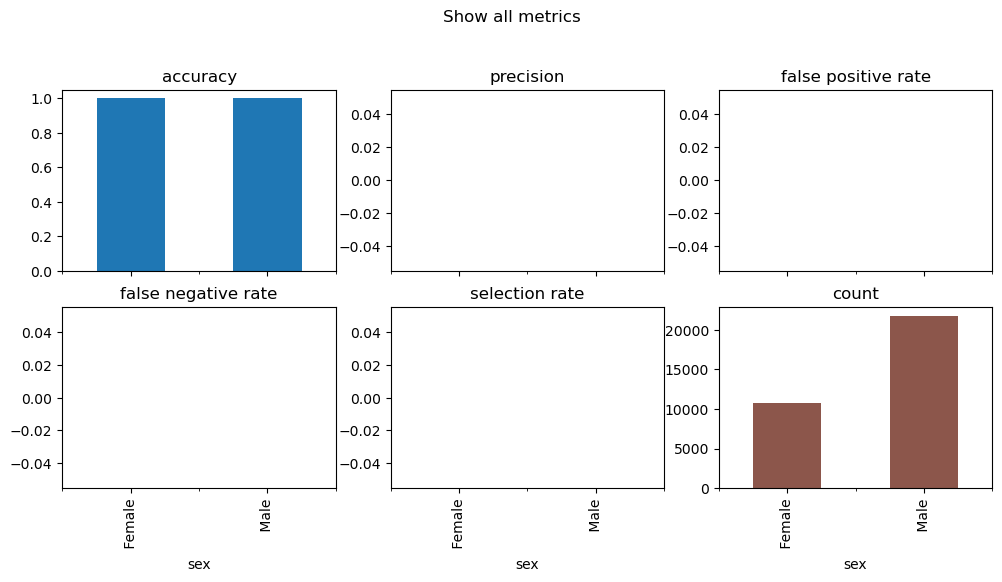

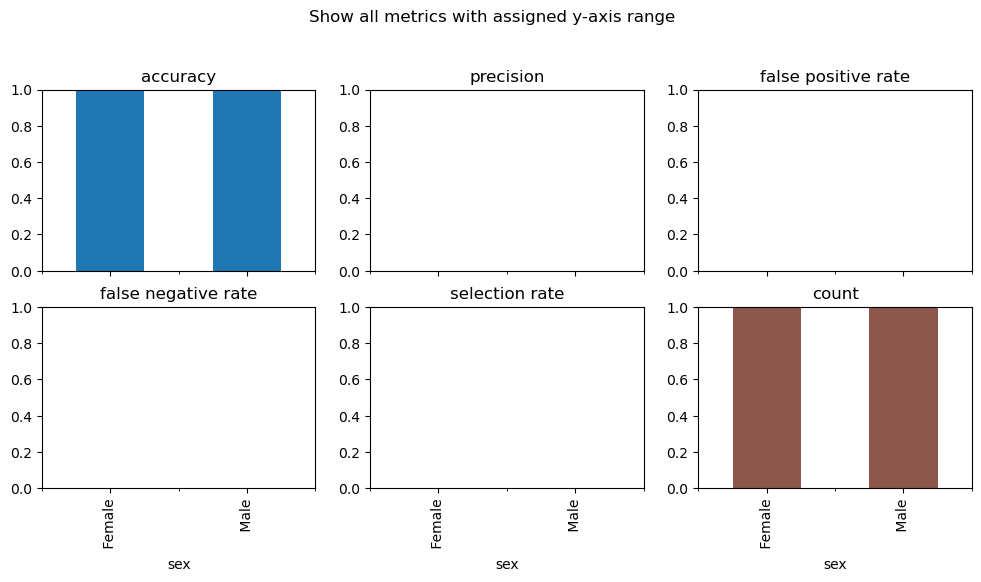

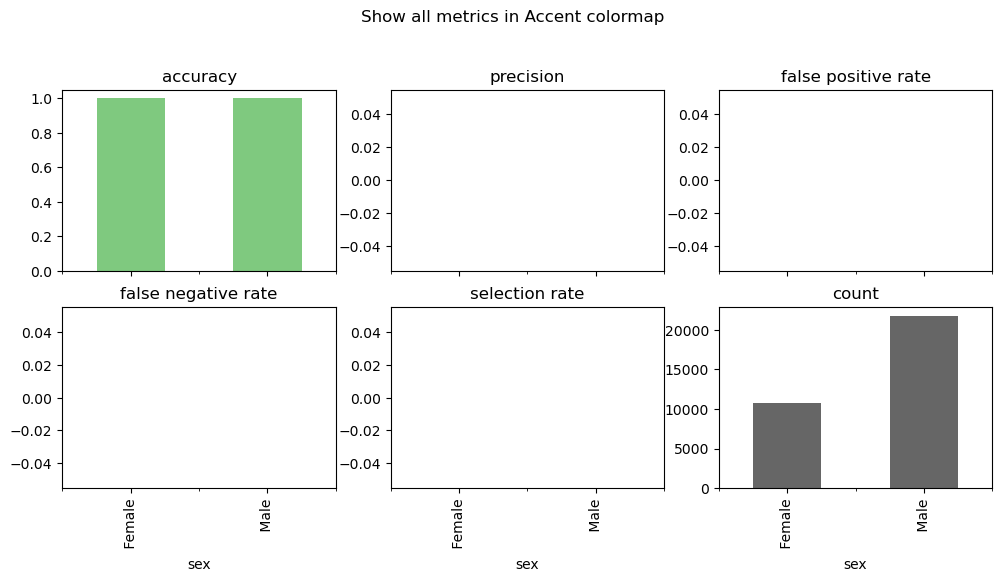

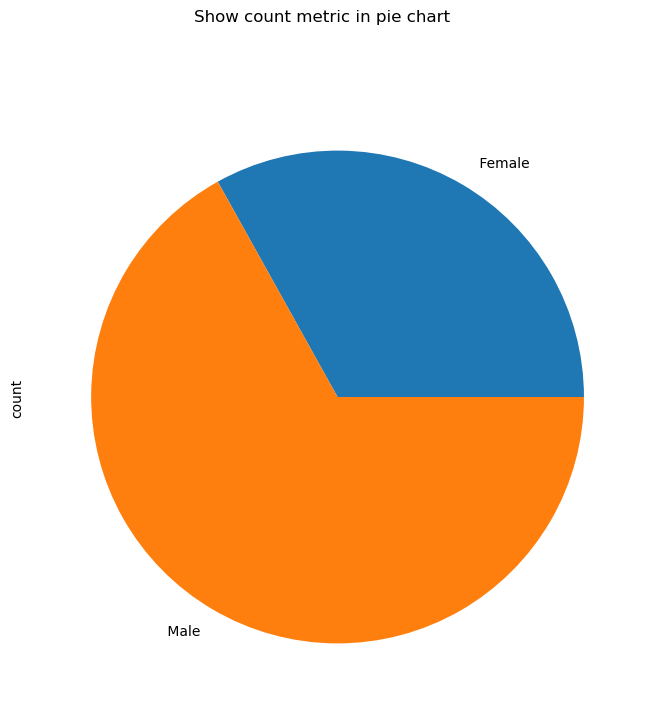

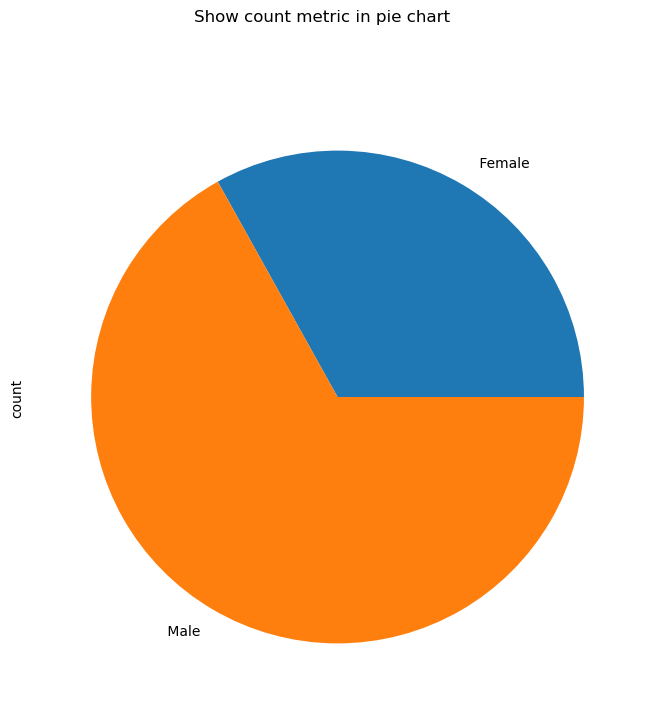

In [3]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

import pandas as pd
from pyspark.sql import SparkSession

# Step 1: Initialize Spark session and read the fixed downloaded data
spark = SparkSession.builder \
    .appName("Read and Process Data") \
    .getOrCreate()

# Path to the fixed downloaded file
file_path = '/mnt/d/FY2024/myPython/myJupyterNB/adult_downloaded.data'

# Read the downloaded file into a PySpark DataFrame
spark_df = spark.read.csv(file_path, header=False, inferSchema=True)

# Define the correct headers
headers = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label'
]

# Convert to pandas DataFrame
df_downloaded = spark_df.toPandas()
df_downloaded.columns = headers

# Remove any extraneous rows if they exist
df_downloaded = df_downloaded[1:].reset_index(drop=True)

# Step 2: Apply transformations similar to fetch_adult

# Convert categorical columns to dummy variables
X = pd.get_dummies(df_downloaded.drop(columns='label'))
# Set y_true based on 'label' column
y_true = (df_downloaded['label'] == '>50K') * 1

# Extract the sensitive feature 'sex'
sex = df_downloaded['sex']


# # data = fetch_adult()
# # X = pd.get_dummies(data.data)
# y_true = (data.target == ">50K") * 1
# sex = data.data["sex"]

classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)
y_pred = classifier.predict(X)

# Analyze metrics using MetricFrame
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

# Customize plots with ylim
metric_frame.by_group.plot(
    kind="bar",
    ylim=[0, 1],
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics with assigned y-axis range",
)

# Customize plots with colormap
metric_frame.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Show all metrics in Accent colormap",
)

# Customize plots with kind (note that we are only plotting the "count" metric here because we are showing a pie chart)
metric_frame.by_group[["count"]].plot(
    kind="pie",
    subplots=True,
    layout=[1, 1],
    legend=False,
    figsize=[12, 8],
    title="Show count metric in pie chart",
)

# Saving plots
fig = metric_frame.by_group[["count"]].plot(
    kind="pie",
    subplots=True,
    layout=[1, 1],
    legend=False,
    figsize=[12, 8],
    title="Show count metric in pie chart",
)

# Don't save file during doc build
if "__file__" in locals():
    fig[0][0].figure.savefig("filename.png")